# Visualización

En este notebook se mira la distribución de tuits por día atendiendo a su polarización obtenida en otros apartados.

In [1]:
import seaborn as sns, numpy as np, pandas as pd, matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer


## Producción de tuits por día

In [2]:
df = pd.read_csv('../data/vacunes_100rt.csv', index_col=0)
df.date = pd.to_datetime(df.date)
df.date = df.date.dt.date
df.head()

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,coordinates,place,username
0,https://twitter.com/LaBandaPindonga/status/138...,2021-04-30,"Anoche dijo Bobeli ""no tenemo' vacuna' po'que ...","Anoche dijo Bobeli ""no tenemo' vacuna' po'que ...",1388281755816321026,"{'username': 'LaBandaPindonga', 'displayname':...",[],[],31,400,...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,NaN,LaBandaPindonga
1,https://twitter.com/HenryChinaski67/status/138...,2021-04-30,Avanzan las negociaciones para producir íntegr...,Avanzan las negociaciones para producir íntegr...,1388274839417495553,"{'username': 'HenryChinaski67', 'displayname':...",[],[],19,157,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,NaN,NaN,NaN,NaN,NaN,NaN,HenryChinaski67
2,https://twitter.com/ribaniez1/status/138827222...,2021-04-30,Castro al médico israelí:\nFue efectivo el con...,Castro al médico israelí:\nFue efectivo el con...,1388272223866265602,"{'username': 'ribaniez1', 'displayname': 'Raúl...",[],[],25,248,...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,NaN,ribaniez1
3,https://twitter.com/EcarleF/status/13882572630...,2021-04-30,El Laboratorio Richmond en Argentina va a fabr...,El Laboratorio Richmond en Argentina va a fabr...,1388257263085830144,"{'username': 'EcarleF', 'displayname': 'Soy Ed...",[],[],22,293,...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,NaN,NaN,NaN,NaN,EcarleF
4,https://twitter.com/DrCKambourian/status/13882...,2021-04-30,Presidente/ Ministra: Dado que ayer estuvieron...,Presidente/ Ministra: Dado que ayer estuvieron...,1388252744176259074,"{'username': 'DrCKambourian', 'displayname': '...",[],[],228,2961,...,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,NaN,DrCKambourian


<AxesSubplot:xlabel='date', ylabel='Count'>

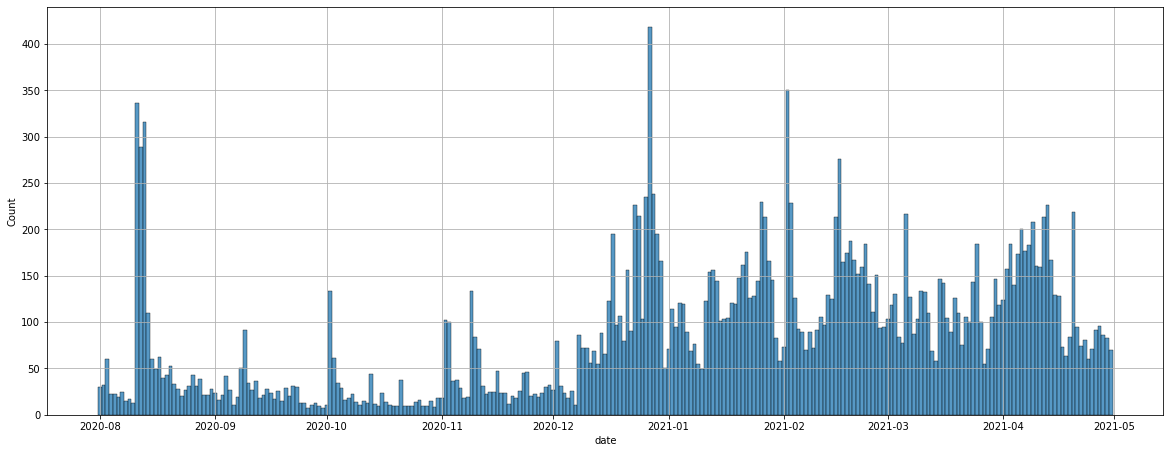

In [3]:
fig, ax = plt.subplots(figsize=(20,7.5))
ax.grid()
sns.histplot(data=df, x='date', ax=ax)

## Producción de tuits polarizados según Vader

In [4]:
df = pd.read_csv('../data/EN/vacunes_100rt_en_textblob.csv', index_col=0)
df.date = pd.to_datetime(df.date)
df.date = df.date.dt.date

sid = SentimentIntensityAnalyzer()
df['polarity_vader'] = df['content'].apply( lambda x: sid.polarity_scores(x)['compound'] )
df['polarity'] = df['polarity_vader']#df['polarity'] * .5 + .5* df['polarity_vader']

In [5]:
df[df.polarity==0].shape

(5071, 28)

In [6]:
df.loc[ (df.polarity >= -1) & (df.polarity <= .05), 'label' ] = 'Negative'
df.loc[ (df.polarity > -.05) & (df.polarity < .05), 'label' ] = 'Neutral'
df.loc[ (df.polarity >= .05) & (df.polarity <= 1), 'label' ] = 'Positive'

In [7]:
labels_dummies = pd.get_dummies(df.label)
df_day = pd.concat([df, labels_dummies], axis=1)
df_day = df_day[['date'] + labels_dummies.columns.tolist() ].groupby(by='date').sum().reset_index().sort_values('date')
df_day

,date,Negative,Neutral,Positive
0,2020-08-01,9,8,13
1,2020-08-02,11,8,13
2,2020-08-03,4,24,32
3,2020-08-04,9,4,9
4,2020-08-05,2,6,14
...,...,...,...,...
268,2021-04-26,45,26,20
269,2021-04-27,36,23,37
270,2021-04-28,33,23,30
271,2021-04-29,31,23,29


Ahora que está ordenado por fechas aprovechamos para mirar si hay una variación apreciable en la producción de tuits total.

/home/marti/.pyenv/versions/capstone/lib/python3.8/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 4.7 sec

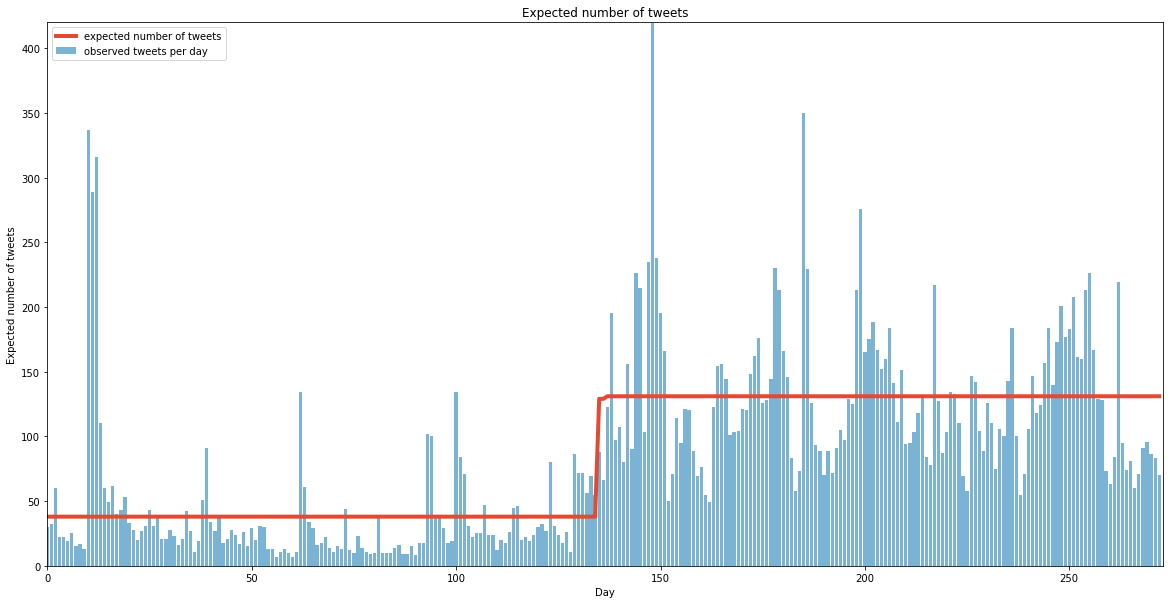

In [14]:
import pymc as pm

n_count_data = df_day.date.count()
count_data = df_day.sum(axis=1)

alpha = 1.0 / df_day.Negative.mean()  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of tweets")
ax.set_xlim(0, n_count_data)
ax.set_xlabel("Day")
ax.set_ylabel("Expected number of tweets")
ax.set_title("Expected number of tweets")
ax.set_ylim(0, count_data.max()+1)
ax.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed tweets per day")

ax.legend(loc="upper left");

### En términos absolutos

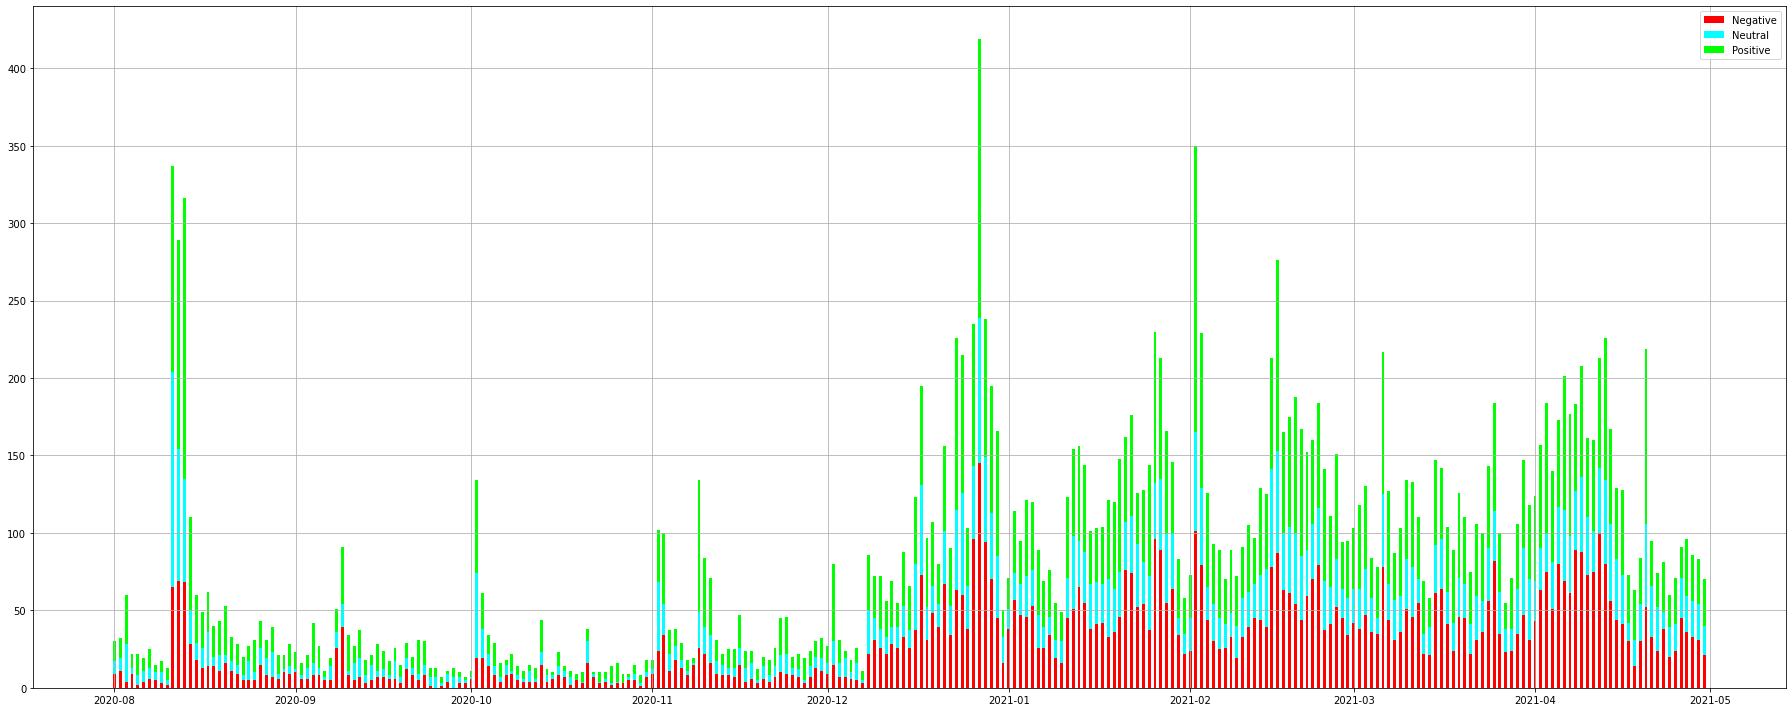

In [15]:
dates = df_day.date
negative = df_day.Negative
neutral = df_day.Neutral
positive = df_day.Positive

fig, ax = plt.subplots(figsize=(25,10))
#sns.set_color_codes("pastel")
#sns.barplot(data=ranking[ranking.label==0], x="user_search",  y='percentage', hue='label', ax=ax)#, hue="label", multiple="stack", ax=ax)

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set_title('Producción total por usuario')
#ax.grid()
#ax.legend(loc='upper right')
#fig.tight_layout()

width = 0.5       # the width of the bars: can also be len(x) sequence

#fig, ax = plt.subplots()

ax.bar(dates, negative, width, label='Negative', color='red')
ax.bar(dates, neutral, width, label='Neutral', bottom=negative, color='#00FFFF')
ax.bar(dates, positive, width, label='Positive', bottom=negative + neutral, color='#00FF00')
#ax.bar(dates, positive, width, label='Positive', color='green')
ax.legend()
ax.grid()


#ax.set_xticklabels(dates, rotation=90);

fig.tight_layout()

### En términos relativos

In [16]:
production_per_day = df_day.sum(axis=1)
df_day_norm = df_day.copy()
for col in df_day.columns[1:]:
    df_day_norm[col] /= production_per_day

In [17]:
df_day_norm

,date,Negative,Neutral,Positive
0,2020-08-01,0.300000,0.266667,0.433333
1,2020-08-02,0.343750,0.250000,0.406250
2,2020-08-03,0.066667,0.400000,0.533333
3,2020-08-04,0.409091,0.181818,0.409091
4,2020-08-05,0.090909,0.272727,0.636364
...,...,...,...,...
268,2021-04-26,0.494505,0.285714,0.219780
269,2021-04-27,0.375000,0.239583,0.385417
270,2021-04-28,0.383721,0.267442,0.348837
271,2021-04-29,0.373494,0.277108,0.349398


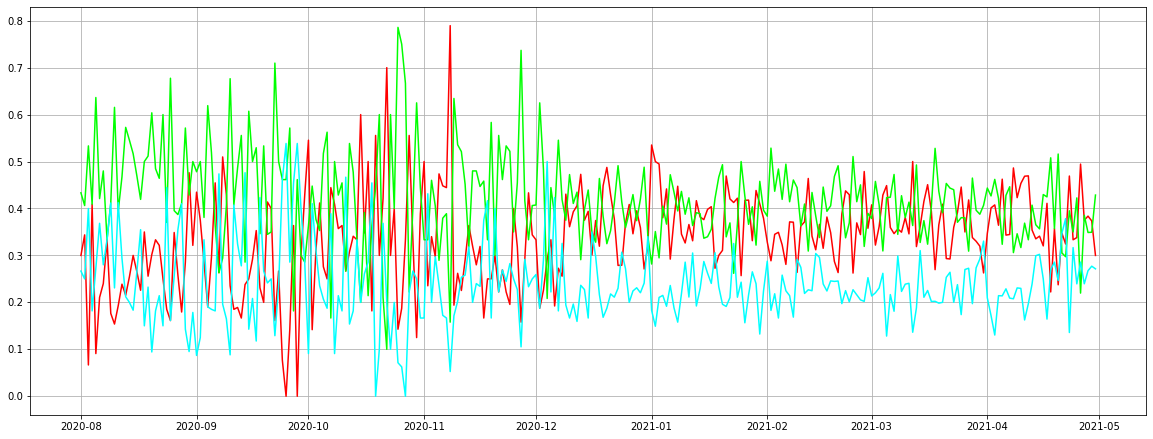

In [18]:
fig, ax = plt.subplots(figsize=(20, 7.5))
ax.grid()

ax.plot(df_day_norm.date, df_day_norm.Negative, color = 'red')
ax.plot(df_day_norm.date, df_day_norm.Positive, color = '#00FF00')
ax.plot(df_day_norm.date, df_day_norm.Neutral, color='#00FFFF')

### Diferencia de la proporción de tuits negativos y positivos

Más arriba está la línea, más tuits negativos respecto positivos hay

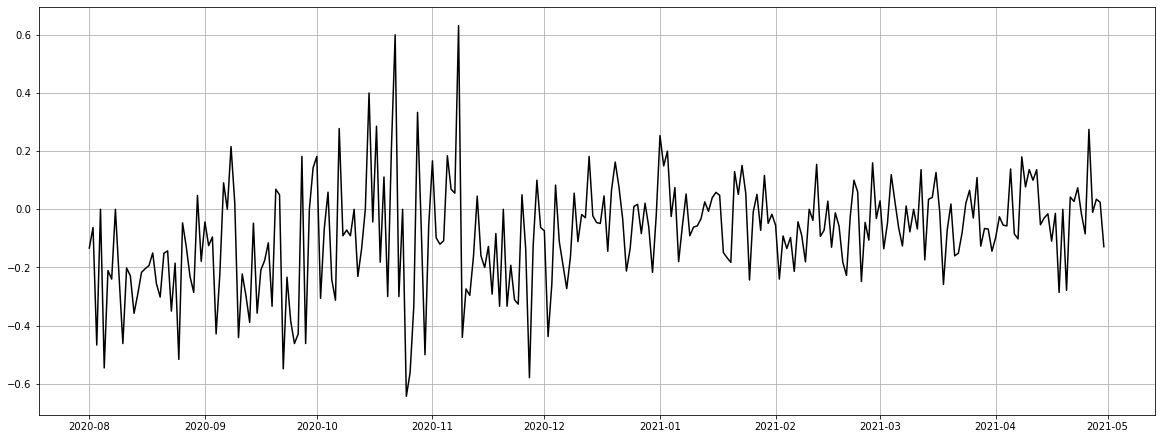

In [19]:
fig, ax = plt.subplots(figsize=(20, 7.5))
ax.grid()

ax.plot(df_day_norm.date, df_day_norm.Negative - df_day_norm.Positive, color = 'black')

/home/marti/.pyenv/versions/capstone/lib/python3.8/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 4.3 sec

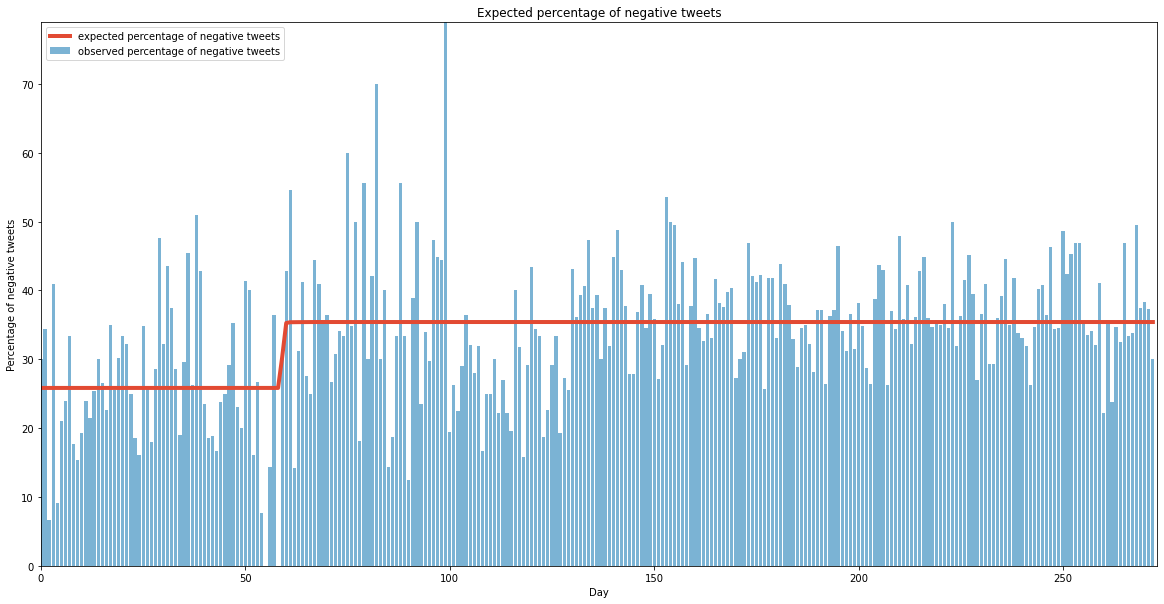

In [20]:
import pymc as pm

n_count_data = df_day_norm.date.count()
count_data = df_day_norm.Negative * 1e2

alpha = 1.0 / (100 * df_day_norm.Negative.mean() )  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected percentage of negative tweets")
ax.set_xlim(0, n_count_data)
ax.set_xlabel("Day")
ax.set_ylabel("Percentage of negative tweets")
ax.set_title("Expected percentage of negative tweets")
ax.set_ylim(0, count_data.max())
ax.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed percentage of negative tweets")

ax.legend(loc="upper left");

/home/marti/.pyenv/versions/capstone/lib/python3.8/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 4.6 sec

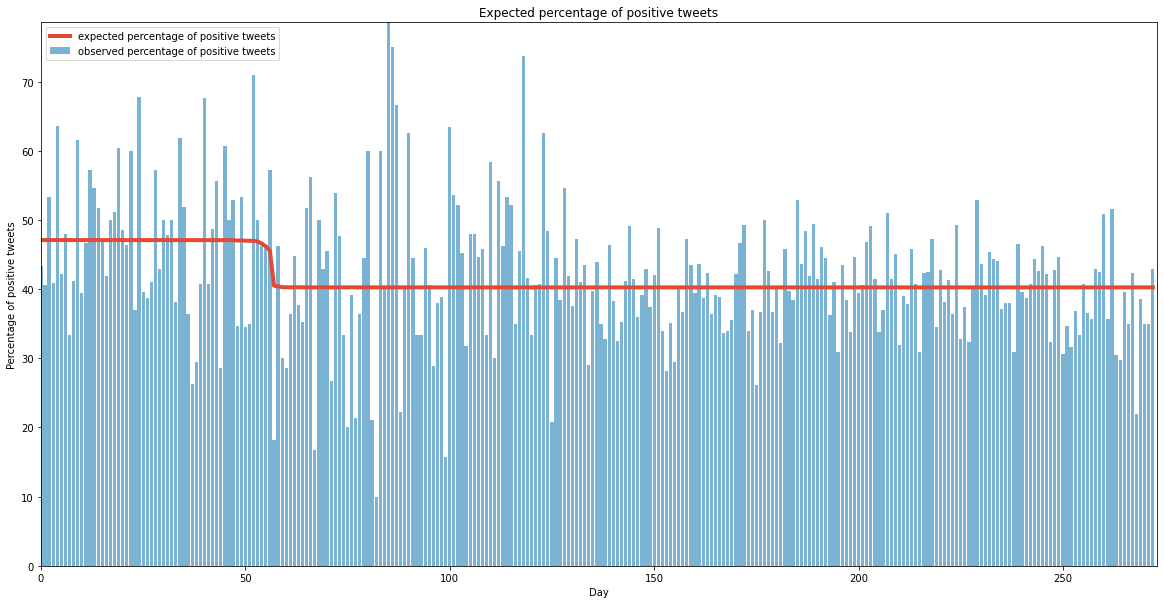

In [21]:
import pymc as pm

n_count_data = df_day_norm.date.count()
count_data = df_day_norm.Positive * 1e2

alpha = 1.0 / (100 * df_day_norm.Positive.mean() )  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected percentage of positive tweets")
ax.set_xlim(0, n_count_data)
ax.set_xlabel("Day")
ax.set_ylabel("Percentage of positive tweets")
ax.set_title("Expected percentage of positive tweets")
ax.set_ylim(0, count_data.max())
ax.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed percentage of positive tweets")

ax.legend(loc="upper left");

/home/marti/.pyenv/versions/capstone/lib/python3.8/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 4.7 sec

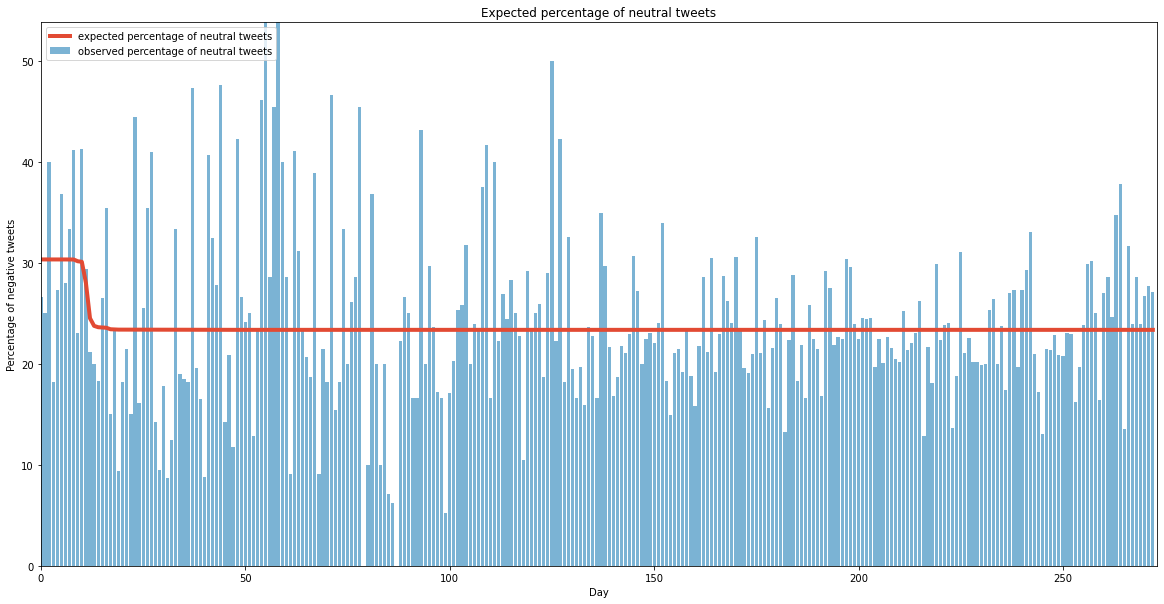

In [22]:

n_count_data = df_day_norm.date.count()
count_data = df_day_norm.Neutral * 1e2

alpha = 1.0 / (100 * df_day_norm.Neutral.mean() )  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected percentage of neutral tweets")
ax.set_xlim(0, n_count_data)
ax.set_xlabel("Day")
ax.set_ylabel("Percentage of negative tweets")
ax.set_title("Expected percentage of neutral tweets")
ax.set_ylim(0, count_data.max())
ax.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed percentage of neutral tweets")

ax.legend(loc="upper left");